# Funny birds to Time Series

In [1]:
import os
import glob
import cv2
import json
import enum
from scipy.spatial.distance import cdist
import numpy as np
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
from PIL import Image
import numpy as np

The enumerate `Center` indicates which center to use to obtain the time series:

- `Center.IMG`. Center of the image.
- `Center.CONTOUR`. The center of each contour. The resulting time series will vary a lot.
- `Center.FIRST_CONTOUR`.

In [2]:
class Center(enum.Enum):
    IMG = 0
    CONTOUR = 1
    FIRST_CONTOUR = 2

    def __str__(self):
        claus = {0: "I", 1: "C", 2: "CO"}

        return claus[self.value]


In [3]:
TEST = False

BODY_COLOR_PARTS = 170
BACKGROUND_COLOR_PARTS = 255
CENTER = Center.FIRST_CONTOUR

BACKGROUND_COLOR_IMG = (85, 85, 153)

## Mask creation

In [4]:
def are_all_similar(a, b, c, tolerance=5):
    """ Determine if all three arrays are similar within a given tolerance.

    Args:
        a: Numpy array of values.
        b: Numpy array of values.
        c: Numpy array of values.
        tolerance: Tolerance level for similarity.

    Returns:
        Boolean numpy array indicating if all three arrays are similar within the tolerance.
    """
    return (
        np.logical_and(abs(a - b) <= tolerance,
                       np.logical_and(abs(a - c) <= tolerance, abs(b - c) <= tolerance))
    )


def get_mask(parts, tolerance=5):
    """ Returns a binary mask from a parts image.

    A parts image indicated each pixel corresponding to a different part. The background are always 

    Args:
        parts:  Image array of shape (H, W, 3), where each pixel's RGB value indicates the part label.
        tolerance: Tolerance level for color similarity.

    Returns:
        Numpy array of shape (H, W) representing the binary mask, where 1 indicates foreground and 0 indicates background.
    """
    parts_unic = parts.reshape(-1, parts.shape[2])
    parts_unic = np.unique(parts_unic, axis=0)
    parts_unic = parts_unic.astype(np.float64)
    diff = are_all_similar(parts_unic[:, 0], parts_unic[:, 1], parts_unic[:, 2], tolerance)

    values = parts_unic[diff]
    mask = np.zeros((256, 256), dtype=np.uint8)
    for val in values:
        if (val[0] == BODY_COLOR_PARTS) or (val[0] == BACKGROUND_COLOR_PARTS):
            continue
        # Binary mask of the object, adding each part
        mask = mask + np.logical_and.reduce(
            (parts[:, :, 0] == val[0], parts[:, :, 1] == val[1], parts[:, :, 2] == val[2]))

    return 1 - mask


def get_time_series(mask, center=None, return_points=False):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = sorted(cnts, key=lambda x: x.size, reverse=True)

    multiple_cnts = (len(cnts) > 1) and (cnts[1].size > 500)

    cnt = cnts[0]

    if center is None:
        M = cv2.moments(cnt)
        center = int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])

    time_series = []

    for point in cnt:
        point = point[0]
        time_series.append(
            float(np.sqrt((point[0] - center[0]) ** 2 + (point[1] - center[1]) ** 2)))

    if return_points:
        return time_series, center, multiple_cnts, cnt
    else:
        return time_series, center, multiple_cnts

In [5]:
if TEST:
    part_map_paths = "./data/funny_birds/v2/test_part_map"
    inter_map_paths = "./data/funny_birds/v2/test_interventions"
else:
    part_map_paths = "./data/funny_birds/v2/train_part_map"
    inter_map_paths = None

IMG_PATH = f"./{part_map_paths}/**/*.png"

In [6]:
images_paths = sorted(glob.glob(IMG_PATH))

classes = set()
for p in images_paths:
    classe = int(p.split(os.path.sep)[-2])

    if classe not in classes:
        classes.add(classe)

cls_dict = {}
for i, classe in enumerate(classes):
    cls_dict[classe] = i

In [7]:
def obtain_parts_id(path: str, cnt):
    new_parts = np.array(Image.open(path))
    new_parts[new_parts == 0] = 32

    res = np.log2(new_parts)
    res[(res % 1) != 0] = -1

    return res[cnt[:, 0, 1], cnt[:, 0, 0]].tolist()

In [8]:
if TEST:
    folder_name = "test"
else:
    folder_name = "train"

for i, img_path in enumerate(tqdm(images_paths)):
    path_parts = img_path.split(os.path.sep)
    bird_class = path_parts[-2]
    bird_class_translated = cls_dict[int(bird_class)]

    file_img_name = path_parts[-1]
    img_name = file_img_name.split(".")[0]

    img_parts = Image.open(img_path)
    img_parts = np.array(img_parts)[:, :, :-1]
    mask = get_mask(img_parts, 40)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    mask[mask != 0] = 1

    if mask.max() == 0:
        print(f"Image {img_path} empty")
        continue

    # Path of the mask
    out_path = os.path.join("output", f"{folder_name}_{CENTER}",
                            str(bird_class_translated).zfill(3), img_name)
    os.makedirs(out_path, exist_ok=True)
    cv2.imwrite(f"./{out_path}/image.png", mask * 255)

    # To Time series
    center_img = mask.shape[0] // 2, mask.shape[1] // 2

    center = None

    time_series, center_cnt, multiple_cnts, cnt = get_time_series(mask.astype(np.uint8), return_points=True)

    if multiple_cnts:
        print(f"Image {str(i).zfill(5)} multiple cnts")
        continue

    
    if CENTER is Center.IMG:
        center = center_img
    elif CENTER is Center.CONTOUR:  # Center of the first contour
        center = center_cnt

    if inter_map_paths is not None and TEST:
        path_new_parts = os.path.join(*[".", "new_parts"] + img_path.split("/")[-2:])
        if os.path.isfile(path_new_parts):
            cnt_parts_id = obtain_parts_id(path_new_parts, cnt)
            with open(f"./{out_path}/time_series_parts.json", "w") as final:
                json.dump(cnt_parts_id, final)
    
    with open(f"./{out_path}/time_series.json", "w") as final:
        json.dump(time_series, final)


    # Saving interventions
    if inter_map_paths is not None and TEST:
        for interv_paths in tqdm(
                sorted(glob.glob(f"./{inter_map_paths}/{bird_class}/{img_name}/*.png")),
                leave=False):
            name_intervent = interv_paths.split(os.path.sep)[-1].split(".")[0]

            intervention = np.array(Image.open(interv_paths))[:, :, :-1]

            logical_mask = 1 - np.logical_and.reduce(
                (intervention[:, :, 0] == BACKGROUND_COLOR_IMG[0],
                 intervention[:, :, 1] == BACKGROUND_COLOR_IMG[1],
                 intervention[:, :, 2] == BACKGROUND_COLOR_IMG[2])
            )
            logical_mask = mask * logical_mask

            time_series, _, _, cnt = get_time_series(logical_mask.astype(np.uint8), center, return_points=True)


            with open(f"./{out_path}/{name_intervent}.json", "w") as final:
                json.dump(time_series, final)

            cv2.imwrite(f"./{out_path}/{name_intervent}.png", logical_mask * 255)

  0%|          | 0/47000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [44]:
with open(f"./{out_path}/cnt_parts_id.json", "w") as final:
    json.dump(cnt_parts_id, final)


./output/test_CO/000/000000/cnt_parts_id.json


In [32]:
np.unique(res)

array([0.   , 1.   , 1.585, 2.   , 3.   , 4.   , 4.586, 5.   ],
      dtype=float16)

Using matplotlib backend: module://ipympl.backend_nbagg


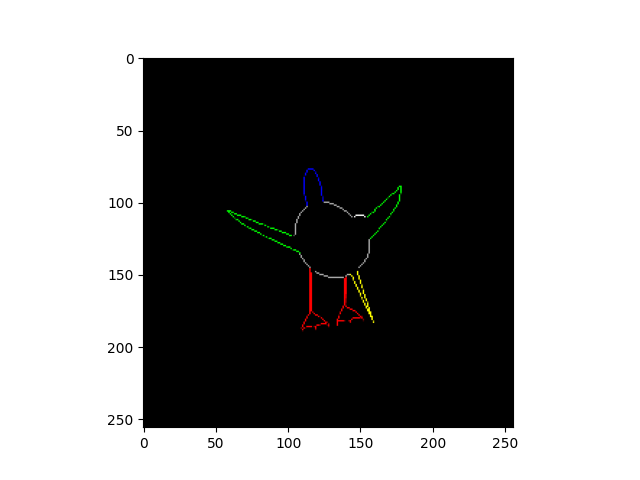

In [110]:
%matplotlib

res = cv2.drawContours(np.zeros(img_parts.shape[:-1]), [cnt], -1, 1, 1)
res = np.repeat(res.reshape((256, 256, 1)), 3, axis=-1) * img_parts
plt.imshow(res.astype(int));

In [111]:
plt.imshow(img_parts)